## Training a model on MNIST

In [16]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import torch.nn as nn
import numpy as np
from tqdm import trange
import datetime

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, KMNIST, EMNIST
from torch.utils.data import Subset

import seaborn as sns
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# DNN mapping 2d input to 1d distribution parameter
# LeNet v5
model = nn.Sequential(
        nn.Conv2d(1, 6, 5, 1),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Conv2d(6, 16, 5, 1),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Flatten(),
        nn.Linear(256, 120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
    )

dist_layer = scod.distributions.CategoricalLogitLayer()

In [3]:
device=torch.device('cpu')
model = model.to(device)

In [5]:
train_dataset = MNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))

mean_loss=0.014296,lr=0.000000: 100%|██████████| 100/100 [13:49<00:00,  8.30s/it]


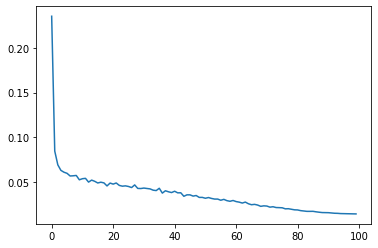

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

losses = []
t = trange(100)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs.to(device))
        dist = dist_layer(outputs)
        loss = -dist.log_prob(targets.to(device))

        mean_loss = loss.mean()

        regularization = torch.sum(torch.stack([torch.norm(p)**2 for p in model.parameters()])) / 2e3

        total_loss = mean_loss + regularization

        total_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
    scheduler.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f,lr=%02f"%(epoch_loss.item(),scheduler.get_last_lr()[0]))
    losses.append(epoch_loss.item())

plt.plot(losses)

In [11]:
# create checkpoint variable and add important data
checkpoint = {
    'epoch': epoch + 1,
    'valid_loss': epoch_loss,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}


In [13]:
save_model_path = "../best_model/mnist_model.pt"
losses_path = "../losses/"

In [14]:
# torch.save(checkpoint, save_model_path)

In [18]:
# # Save train losses and valid losses
# fname = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +'.npz' 
# np.savez(losses_path + fname, train_loss_values = losses)